In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import rasterio
from netCDF4 import Dataset

In [2]:
catch_path = os.path.join('..','data/raw/catchments')
polygons = gpd.read_file(os.path.join(catch_path,'regen_catchments_right.shp'))

<Axes: >

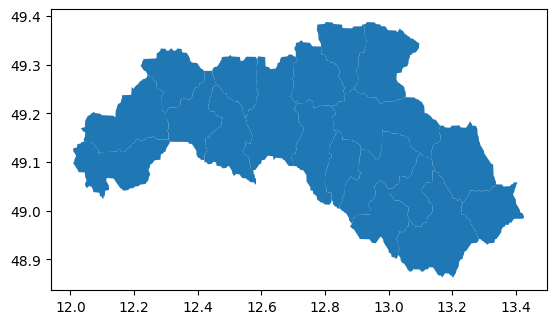

In [3]:
polygons.plot()

<Axes: >

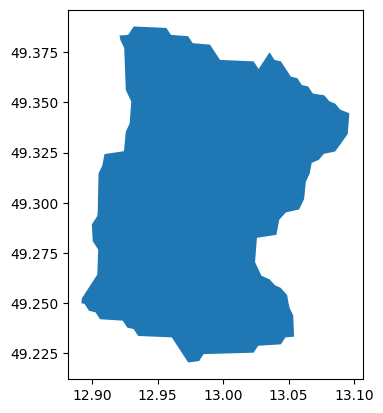

In [4]:
test = polygons[polygons['HYBAS_ID'] == 2111140970]
test.plot()

In [5]:
path = 'data/raw/meteo'
meteo_dir = os.listdir(os.path.join('..',path))
meteo_dir
year = 2023

ds = xr.open_dataset(os.path.join('..',path,'2023_ERA5_Regen.nc'))

In [6]:
ds['tp']

<xarray.DataArray 'tp' (time: 8760, latitude: 9, longitude: 9)> Size: 6MB
[709560 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 36B 12.0 12.25 12.5 12.75 ... 13.5 13.75 14.0
  * latitude   (latitude) float32 36B 50.0 49.75 49.5 49.25 ... 48.5 48.25 48.0
  * time       (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
Attributes:
    units:      m
    long_name:  Total precipitation

In [7]:
ds_daily = xr.Dataset({
    'tp': ds['tp'].resample(time='D').mean(dim='time'),
    'ssr': ds['ssr'].resample(time='D').mean(dim='time'),
    'd2m': ds['d2m'].resample(time='D').mean(dim='time'),
    't2m': ds['t2m'].resample(time='D').mean(dim='time'),
    'sp': ds['sp'].resample(time='D').mean(dim='time')
})
ds_daily

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 9, latitude: 9, time: 365)
Coordinates:
  * longitude  (longitude) float32 36B 12.0 12.25 12.5 12.75 ... 13.5 13.75 14.0
  * latitude   (latitude) float32 36B 50.0 49.75 49.5 49.25 ... 48.5 48.25 48.0
  * time       (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
Data variables:
    tp         (time, latitude, longitude) float64 237kB 8.674e-19 ... 0.0001246
    ssr        (time, latitude, longitude) float64 237kB 1.499e+05 ... 1.609e+05
    d2m        (time, latitude, longitude) float64 237kB 279.1 279.0 ... 273.2
    t2m        (time, latitude, longitude) float64 237kB 283.5 283.3 ... 275.3
    sp         (time, latitude, longitude) float64 237kB 9.564e+04 ... 9.426e+04

In [39]:
# out_path = os.path.join('..','data/processed/meteo')
# file_name = str(year) + '_daily_era5_meteo' + '.nc'
# ds_daily.to_netcdf(os.path.join(out_path,file_name))

In [8]:
lon_list = np.arange(12,14.25,0.25)
lat_list = np.arange(48,50.25,0.25)


test['geometry'].clip_by_rect(xmin = 12.0,xmax = 12.25,ymin =49,ymax = 49.25).area.values[0]/(0.25*0.25)

/var/folders/4t/_4f_khl520s03z4ltmxqlnsh0000gn/T/ipykernel_44954/4086400244.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  test['geometry'].clip_by_rect(xmin = 12.0,xmax = 12.25,ymin =49,ymax = 49.25).area.values[0]/(0.25*0.25)


0.0

In [61]:
#function to calculate the statistics for a catchment

def calc_zonal_stats(geom,ds,time):
    #some weird geopandas things
    gdf = gpd.GeoDataFrame(geometry=[geom])
    geom = gdf['geometry']
    area = geom.area
    lon_list = np.arange(12,14,0.25)
    lat_list = np.arange(48,50,0.25)
    splits = np.empty(0)
    totals = np.empty(0)
    for var in list(ds.keys()):
        for lat in lat_list:
            for lon in lon_list:
                clip_area = geom.clip_by_rect(xmin = lon, xmax = lon + 0.25, ymin = lat, ymax = lat + 0.25).area.values[0]
                if clip_area == 0:
                    continue
                var_value = ds[var].sel(latitude=lat, longitude=lon,time = time, method='nearest',tolerance = 0.001).values
                splits = np.append(splits,(clip_area/area) * var_value)
        totals = np.append(totals,splits.sum())
    return tuple(totals)


In [76]:
help_df = pd.DataFrame(columns=[['tp','ssr','d2m','t2m','sp','date']])
help_df['tp'],help_df['ssr'],help_df['d2m'],help_df['t2m'],help_df['sp'] = zip(*polygons.apply(lambda row: calc_zonal_stats(geom = row['geometry'],ds = ds_daily,time = '2023-01-01'),axis = 1))
help_df['date'] = pd.to_datetime('2023-01-01')


In [77]:
help_df

,tp,ssr,d2m,t2m,sp,date
0,8.673617e-19,163547.213493,163824.958404,164106.833158,259888.515590,2023-01-01
1,8.673617e-19,162815.749667,163093.703349,163375.668524,259621.501495,2023-01-01
2,4.522911e-08,164812.546285,165091.292168,165373.260338,262492.009622,2023-01-01
3,8.673617e-19,164609.092478,164887.488797,165168.903356,262062.903118,2023-01-01
4,8.673617e-19,164433.853091,164711.853686,164993.255776,261381.758688,2023-01-01
5,8.673617e-19,166507.085076,166785.227315,167065.928615,263982.884594,2023-01-01
6,8.673617e-19,168332.043876,168609.455915,168889.925085,264357.413824,2023-01-01
7,6.451933e-07,167577.999257,167856.657962,168138.784515,265201.865289,2023-01-01
8,8.673617e-19,167644.489577,167922.754578,168203.626608,265254.390478,2023-01-01
9,8.673617e-19,167997.578759,168275.303384,168555.669756,264833.590709,2023-01-01


In [82]:
df_final = pd.DataFrame(columns=[['tp','ssr','d2m','t2m','sp','date']])
for t in ds_daily['time'].values:
    day = np.datetime64(t,'D')
    help_df = pd.DataFrame(columns=[['tp','ssr','d2m','t2m','sp','date','catch']])
    help_df['tp'],help_df['ssr'],help_df['d2m'],help_df['t2m'],help_df['sp'] = zip(*polygons.apply(lambda row: calc_zonal_stats(geom = row['geometry'],ds = ds_daily,time = '2023-01-01'),axis = 1))
    help_df['date'] = day
    df_final = pd.concat((df_final,help_df),axis = 0)
    print(day)
df_final.reset_index(drop = True)

/var/folders/4t/_4f_khl520s03z4ltmxqlnsh0000gn/T/ipykernel_44954/4222586277.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat((df_final,help_df),axis = 0)


2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

,tp,ssr,d2m,t2m,sp,date
0,8.673617e-19,163547.213493,163824.958404,164106.833158,259888.515590,2023-01-01
1,8.673617e-19,162815.749667,163093.703349,163375.668524,259621.501495,2023-01-01
2,4.522911e-08,164812.546285,165091.292168,165373.260338,262492.009622,2023-01-01
3,8.673617e-19,164609.092478,164887.488797,165168.903356,262062.903118,2023-01-01
4,8.673617e-19,164433.853091,164711.853686,164993.255776,261381.758688,2023-01-01
...,...,...,...,...,...,...
6930,8.673617e-19,168171.001968,168448.582971,168728.933672,264716.182893,2023-12-31
6931,8.673617e-19,169074.553893,169351.762453,169632.202523,264881.735975,2023-12-31
6932,8.673617e-19,170218.099957,170495.065083,170775.661740,265785.141253,2023-12-31
6933,8.673617e-19,170672.855704,170950.249596,171229.902884,268429.090756,2023-12-31


In [23]:
ddf = pd.DataFrame()
ddf = pd.concat((ddf,help_df),axis = 1)
ddf['date'] = pd.to_datetime('2023-01-01')
ddf

,0,date
0,"{'tp': 8.673617379884043e-19, 'ssr': 163547.21...",2023-01-01
1,"{'tp': 8.673617379884034e-19, 'ssr': 162815.74...",2023-01-01
2,"{'tp': 4.5229107985195177e-08, 'ssr': 164812.5...",2023-01-01
3,"{'tp': 8.673617379884043e-19, 'ssr': 164609.09...",2023-01-01
4,"{'tp': 8.673617379884035e-19, 'ssr': 164433.85...",2023-01-01
5,"{'tp': 8.67361737988404e-19, 'ssr': 166507.085...",2023-01-01
6,"{'tp': 8.673617379884014e-19, 'ssr': 168332.04...",2023-01-01
7,"{'tp': 6.451933160805748e-07, 'ssr': 167577.99...",2023-01-01
8,"{'tp': 8.673617379884027e-19, 'ssr': 167644.48...",2023-01-01
9,"{'tp': 8.673617379884045e-19, 'ssr': 167997.57...",2023-01-01


In [41]:
df_final.iloc[19].values[0]

Timestamp('2023-01-01 00:00:00')

In [258]:
ds_daily['t2m'].sel(longitude = 12,latitude = 50, time = '2023-01-01').values

array(283.50437186)

<Axes: >

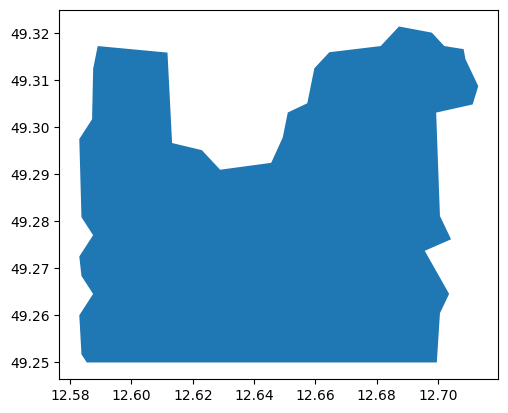

In [227]:
test['geometry'].clip_by_rect(xmin = 12.5,xmax = 12.75,ymin =49.25,ymax = 49.5).plot()

In [229]:
test['geometry'].area - test['geometry'].clip_by_rect(xmin = 12.5,xmax = 12.75,ymin =49.25,ymax = 49.5).area - test['geometry'].clip_by_rect(xmin = 12.5,xmax = 12.75,ymin =49,ymax = 49.25).area

/var/folders/4t/_4f_khl520s03z4ltmxqlnsh0000gn/T/ipykernel_17299/3345035736.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  test['geometry'].area - test['geometry'].clip_by_rect(xmin = 12.5,xmax = 12.75,ymin =49.25,ymax = 49.5).area - test['geometry'].clip_by_rect(xmin = 12.5,xmax = 12.75,ymin =49,ymax = 49.25).area


5   -6.938894e-18
dtype: float64

In [69]:
import hydroeval as he

inputsulations = [5.3, 4.2, 5.7, 2.3]
targetsuations = [4.7, 4.3, 5.5, 2.7]

nse = he.evaluator(he.nse, inputsulations, targetsuations)

kge, r, alpha, beta = he.evaluator(he.kge, inputsulations, targetsuations)
kge[0]

0.7066232000405392

In [42]:
import torch.nn as nn
import torch
class KGE_Loss(nn.Module):
    def __init__(self):
        super(KGE_Loss, self).__init__()
        
    def forward(self,inputs,targets):
        r = torch.corrcoef(torch.stack((inputs,targets)))[0][1]
        alpha = inputs.std()/targets.std()
        beta = inputs.mean()/targets.mean()
        kge = 1-torch.sqrt(torch.square(r-1) + torch.square(alpha-1) + torch.square(beta-1))
        return kge